<a href="https://colab.research.google.com/github/dev-SARDAR/FMML_Assignment-2022/blob/main/Module9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2023-06-06 18:52:19--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.41.23, 18.160.41.107, 18.160.41.63, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.41.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   209MB/s    in 0.2s    

2023-06-06 18:52:20 (209 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


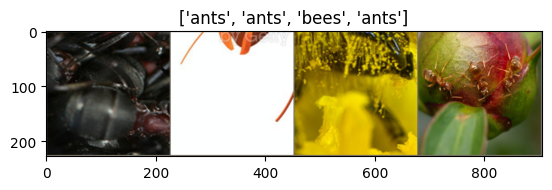

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 83.3MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.6171 Acc: 0.7008

Epoch 1/4
----------
Loss: 0.5790 Acc: 0.7787

Epoch 2/4
----------
Loss: 0.6256 Acc: 0.7869

Epoch 3/4
----------
Loss: 0.6180 Acc: 0.7500

Epoch 4/4
----------
Loss: 0.3792 Acc: 0.8402



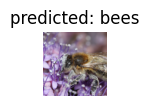

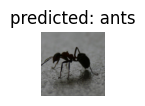

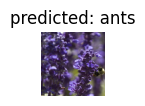

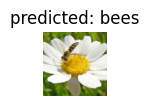

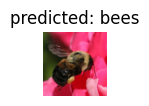

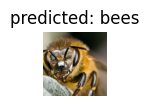

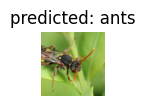

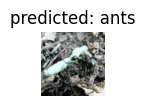

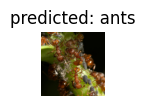

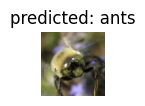

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


##Q) What is the significance of using data augmentations like resize, crop etc on training data?
##Answer)
* Increased dataset size: Data augmentation artificially increases the size of the training dataset by applying various transformations to existing data samples. This larger dataset helps prevent overfitting, where the model becomes too specialized to the training data and performs poorly on unseen examples.

* Improved generalization: By applying random transformations to the training data, data augmentation encourages the model to learn invariant features and patterns. This improves the model's ability to generalize well to new, unseen examples, as it learns to recognize objects or patterns despite variations in size, rotation, lighting conditions, and other factors.

* Robustness to input variations: Data augmentation exposes the model to a wide range of variations, such as different image sizes, aspect ratios, and viewpoints. This makes the model more robust and capable of handling real-world scenarios where the input data may have natural variations.

* Reduced overfitting: Overfitting occurs when a model learns to memorize specific training examples rather than learning the underlying patterns. By augmenting the data with various transformations, the model encounters similar but slightly different instances during training, reducing the chance of overfitting and improving its ability to generalize.

* Increased diversity of training examples: Data augmentation allows the generation of new training examples that exhibit variations not present in the original dataset. This diversity exposes the model to a wider range of data patterns and helps it learn more robust and discriminative features.

* Balanced class representation: In classification tasks with imbalanced class distributions, data augmentation techniques can be used to artificially increase the representation of minority classes. By generating new synthetic samples for underrepresented classes, the model can better learn to distinguish between different classes and avoid biased predictions.

Overall, data augmentation techniques play a crucial role in improving the performance, robustness, and generalization of machine learning models, particularly in computer vision tasks. By augmenting the training data, models can learn to recognize and understand objects and patterns in a more flexible and adaptable manner.


---



##Q) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)
##Answer)

In [11]:
from torchvision import models

model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.7260 Acc: 0.5123

Epoch 1/4
----------
Loss: 0.7407 Acc: 0.5574

Epoch 2/4
----------
Loss: 0.8261 Acc: 0.5492

Epoch 3/4
----------
Loss: 0.8398 Acc: 0.5779

Epoch 4/4
----------
Loss: 0.8064 Acc: 0.5574



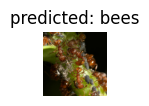

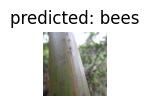

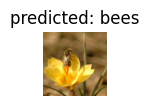

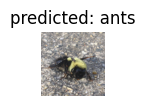

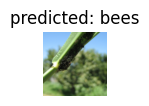

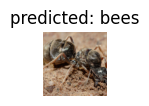

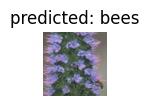

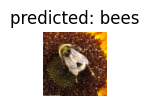

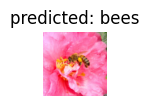

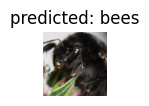

In [13]:
visualize_model(model_ft)

* Learning rich feature representations: Pretraining a model on a large dataset allows it to learn meaningful and rich feature representations that are transferable to other tasks. These pretrained models have already learned to recognize a wide variety of objects, edges, textures, and other visual patterns.

* Leveraging knowledge from a large dataset: The ImageNet dataset, on which models like ResNet are typically pretrained, contains millions of diverse images from various categories. By using a pretrained model, you benefit from the knowledge gained from this extensive dataset, enabling the model to generalize well to other tasks with limited labeled data.

*  Regularization and generalization: Pretrained models have already undergone regularization techniques, such as dropout and weight decay, during their original training. These techniques help prevent overfitting and improve the model's generalization ability, which can be particularly beneficial when training on smaller datasets.

4. Faster convergence: When starting from pretrained weights, the model already has a good initialization point. This initialization helps the model converge faster during training, reducing the time required to achieve good performance.

If you train a ResNet model from scratch (i.e., with `pretrained=False`), the performance of the model might be lower compared to using a pretrained model. The model would need to learn feature representations from scratch, which can be challenging, especially if the available dataset is small or lacks diversity. It may require significantly more data and longer training time to achieve comparable performance to a pretrained model.

However, it's worth noting that the specific performance you would get without using a pretrained ResNet model can vary depending on the dataset, the complexity of the task, the size of the model, and other factors. In some cases, with a sufficiently large and diverse dataset, training from scratch might still yield reasonably good results.

---



##Q) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?
##Answer)
The performance of a pretrained ResNet model on a new task, such as the "ants vs bees" dataset, can vary depending on the similarity between the pretrained dataset and the target dataset. If the pretrained model was trained on a significantly different dataset, the performance may not be as good compared to using a model pretrained on a similar task or dataset. Here are a few considerations:

* Domain similarity: The performance of a pretrained model is generally higher when the pretrained dataset and the target dataset share similar characteristics. If the pretrained dataset is substantially different from the "ants vs bees" dataset—for example, if it was trained on medical images or satellite imagery—there may be limited transferable knowledge, and the performance may suffer.

* Feature generalization: Pretrained models capture general image features that can be useful across different tasks. Lower-level features like edges, textures, and colors are typically shared among different image datasets. However, higher-level features specific to the pretrained dataset might not be as relevant to the target dataset. This mismatch in feature relevance can impact performance.

* Overfitting and fine-tuning: Fine-tuning a pretrained model involves updating the weights during training to adapt to the new task. If the pretrained model is too different from the target dataset, there is a risk of overfitting, where the model fails to generalize well to the new data. In such cases, it may be necessary to perform careful regularization techniques or limit the extent of fine-tuning to prevent overfitting.

* Dataset size and diversity: The size and diversity of the target dataset also play a crucial role. If the "ants vs bees" dataset is relatively small, the pretrained model may struggle to capture the specific characteristics of the target classes. In such cases, additional data augmentation, transfer learning techniques, or training on a larger dataset may be beneficial.

In summary, if the pretrained model was trained on a significantly different dataset than the "ants vs bees" data, the performance may not be as good as using a model pretrained on a more relevant dataset. However, the specific impact on performance can vary depending on the nature of the datasets, the level of domain similarity, and the amount of available target data. It's often recommended to start with a pretrained model and fine-tune it on the target dataset, monitoring performance closely to determine the optimal approach.

---

